# Trabecular metrics from microCT dataset of cylindrical sample. Including misalignment of the cylinder axis

- By: [Alfonso Dario Santamaria](https://github.com/AlphoSM), [Gianluca Iori](https://github.com/gianthk), [Gianluigi Crimi](https://github.com/gcrimi), Martino Pani, Enrico Schileo, Fulvia Taddei, Giulia Fraterrigo, 2025
  
- Code license: MIT
- Narrative license: CC-BY-NC-SA


---

# 📌 Aims

The aim of this notebook is to measure the misalignment, create the binary mask and trabecular microstructural metrics of a trabecular bone sample acquired by micro-CT (uCT).  
We will process the scanned data, segment the structure, and calculate the best-fit axis to quantify the deviation from perfect alignment.

---


## Configuration and imports

In [1]:
import sys
sys.path.append('./../../')

In [2]:
import os
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import shutil

from scipy import ndimage, misc
from skimage import measure, morphology
from skimage.filters import gaussian, threshold_otsu

import math
import meshio

/var/folders/2t/kf558mtn2y5gvhjbmy_5g86w0000gn/T/ipykernel_59940/3522155401.py:8: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import ndimage, misc


In [3]:
import ciclope
from ciclope.core import tetraFE

from ciclope.utils.recon_utils import read_tiff_stack, plot_midplanes
from ciclope.utils.preprocess import remove_unconnected, replace_ElType_ref
from ciclope.utils.postprocess import calculate_total_force, sample_height
from ciclope.utils.timer import Timer
from ciclope.utils import misalignment
from ciclope.utils.misalignment import circle_slice_uCT_trab_bone, best_fit_segment_3d

/Users/gianthk/micromamba/envs/ciclope/lib/python3.11/site-packages/ciclope/utils/postprocess.py:16: RuntimeWarning: ParaView.simple is required!
  warnings.warn("ParaView.simple is required!", RuntimeWarning)


In [ ]:
import ormir_xct
from ormir_xct.util.hildebrand_thickness import calc_structure_thickness_statistics

In [5]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

## Load input data

In [6]:
input_data = './../../test_data/LHDL/Ti_2923_D_1/resampled/Ti_2923_D_1_0000.tif'

Input data description

|Scan parameters|   |
|:-|:-|
|Lab|LTM@IOR Bologna|
|Sample|Human trabecular bone|
|Voxel size|19.5 micron|
|Preliminary operations|cropped to 257x257x495 (diameter ≈ 5mm)|

Read the input data and define an array of the voxelsize

In [7]:
data_3D = read_tiff_stack(input_data, range=[0,257])
vs = np.ones(3)*19.5e-3 # [mm]

Inspect the dataset

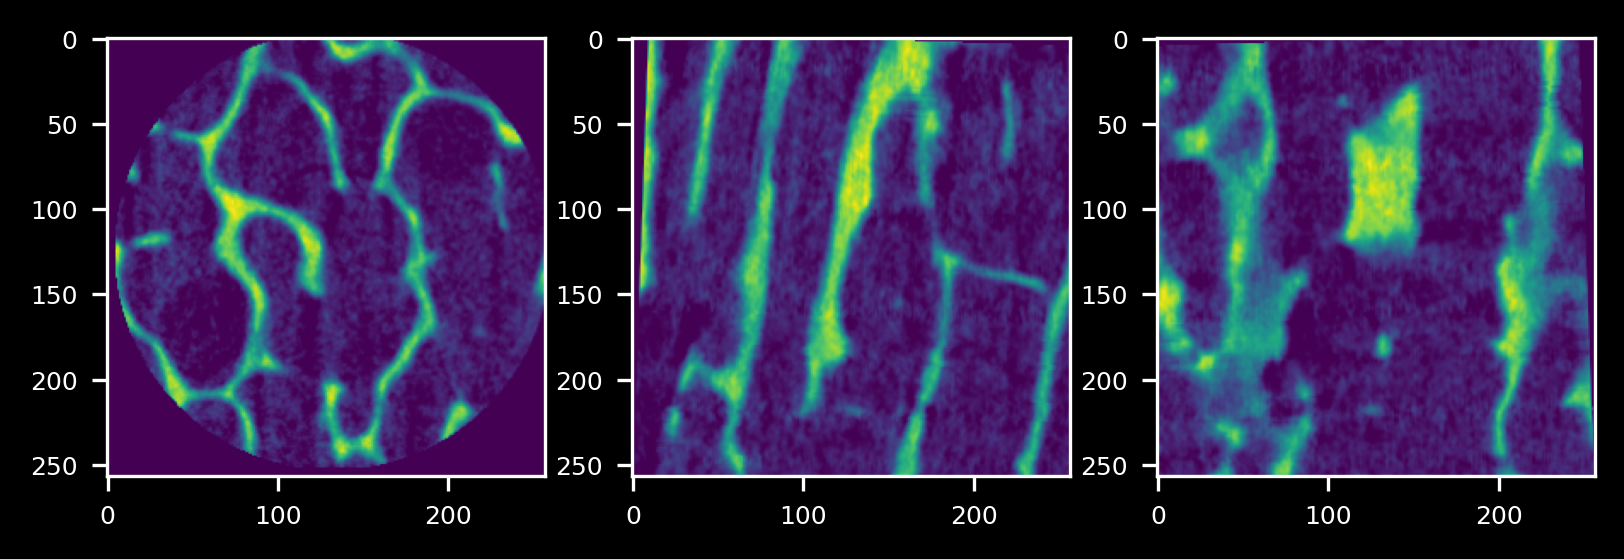

In [8]:
plot_midplanes(data_3D)
plt.show()

## Pre-processing

### Gaussian smooth

In [9]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

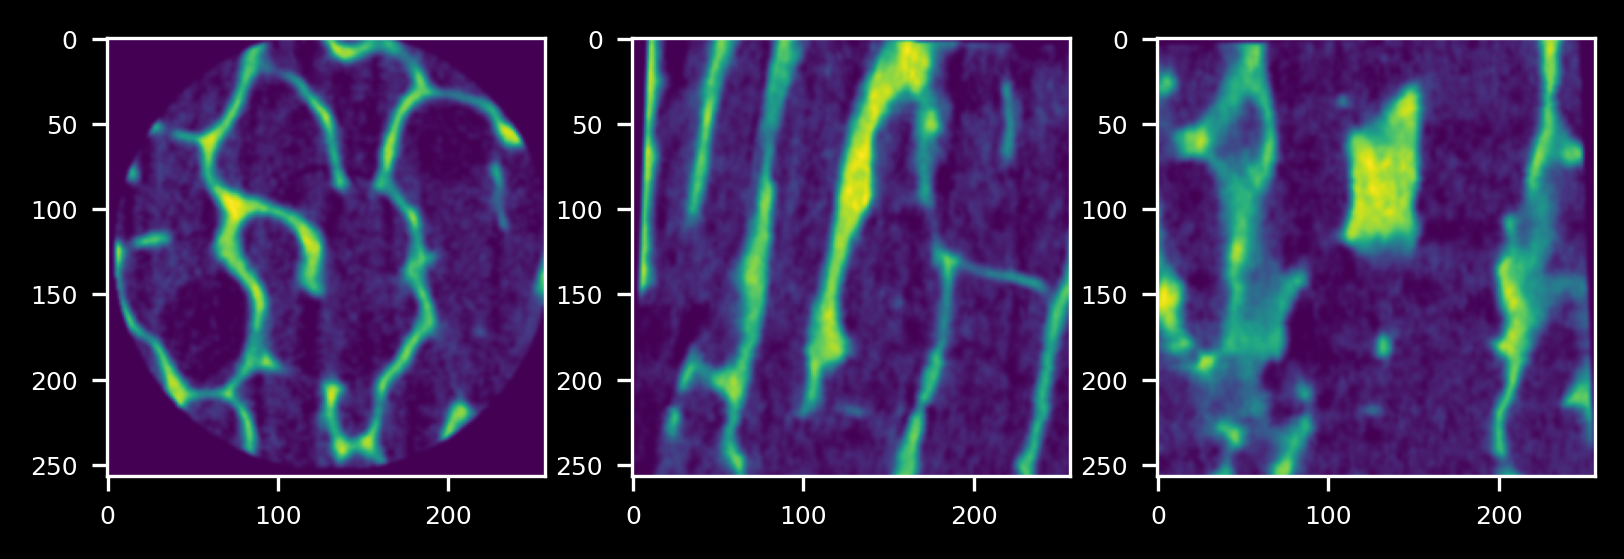

In [10]:
# Inspect again the dataset
plot_midplanes(data_3D)
plt.show()

### Thresholding
Use Otsu's method

In [11]:
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 75.8765563570748


In [12]:
BW = data_3D >= T

Inspect binary mask

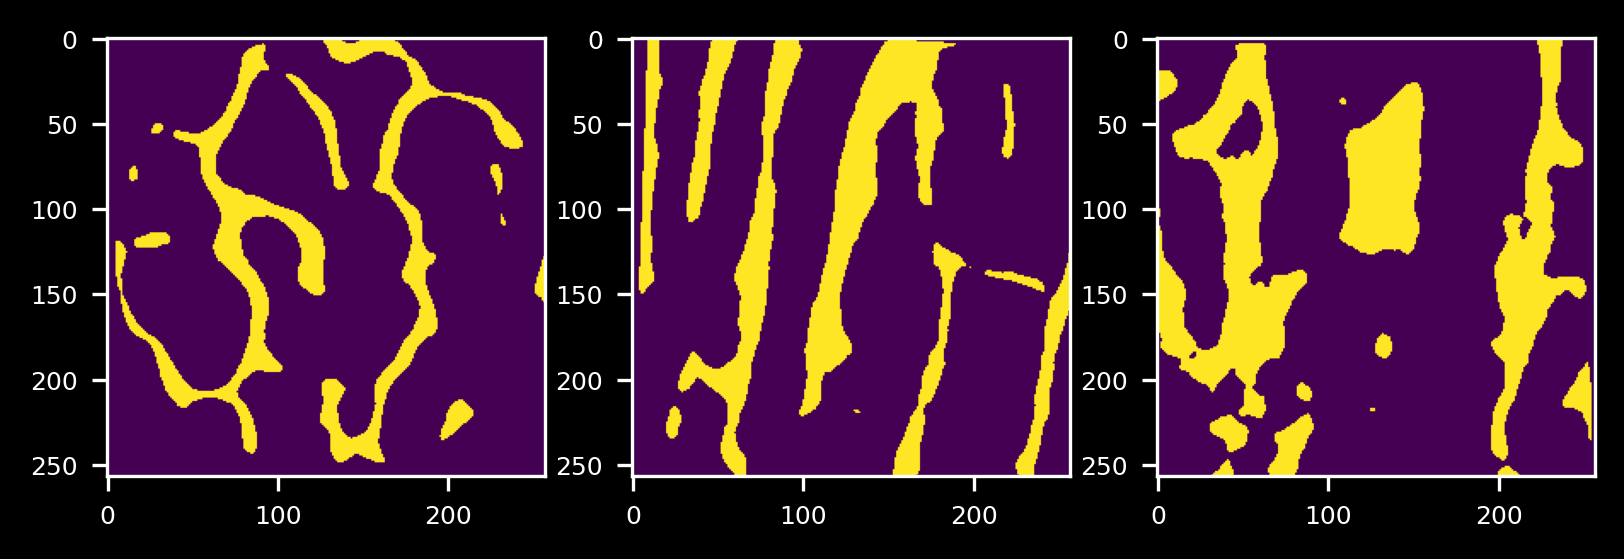

In [13]:
plot_midplanes(BW)
plt.show()

z-levels: assume sequential integer indices or actual Z spacing

In [14]:
z_levels = np.arange(0, BW.shape[0])

## Slice Analysis & Ellipse Fitting

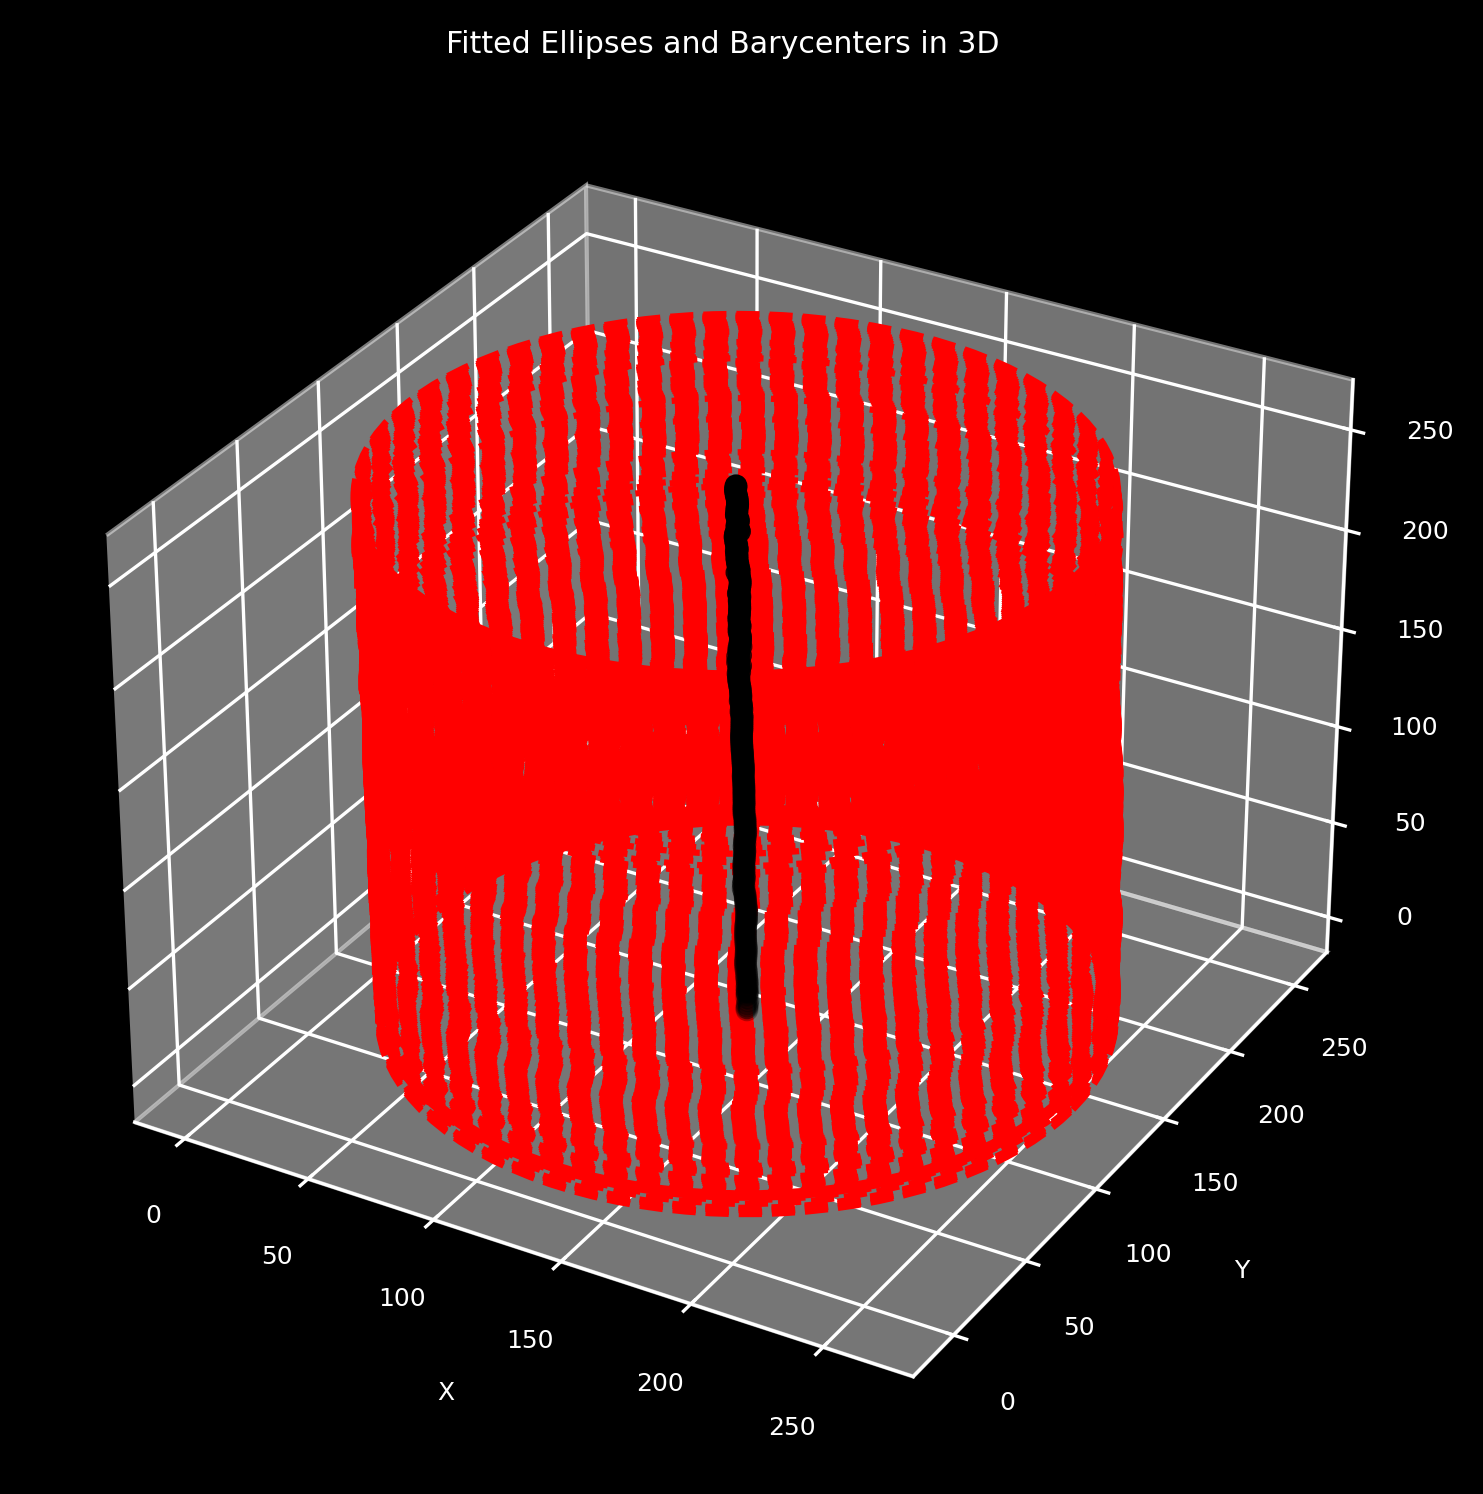

In [20]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Initialize lists
ecc_list = []   # eccentricities
G_list = []     # [X, Y, Z]
r_list = []     # radii

for z in range(BW.shape[0]):
    slice_2d = BW[z]
    C, a, b, coords, hull_pts = circle_slice_uCT_trab_bone(slice_2d, z, bin_thresh=BW, ax=ax)
    G_list.append([C[0], C[1], z])
    ecc_list.append(a/b)
    r_list.append((a + b)/2)

# Scatter barycenters for visibility
if G_list:
    G = np.array(G_list)
    ax.scatter(G[:,0], G[:,1], G[:,2], c='k', s=20)
    
# Label axes and show
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Fitted Ellipses and Barycenters in 3D')
plt.show()

## Compute Best-Fit Line through Barycenters

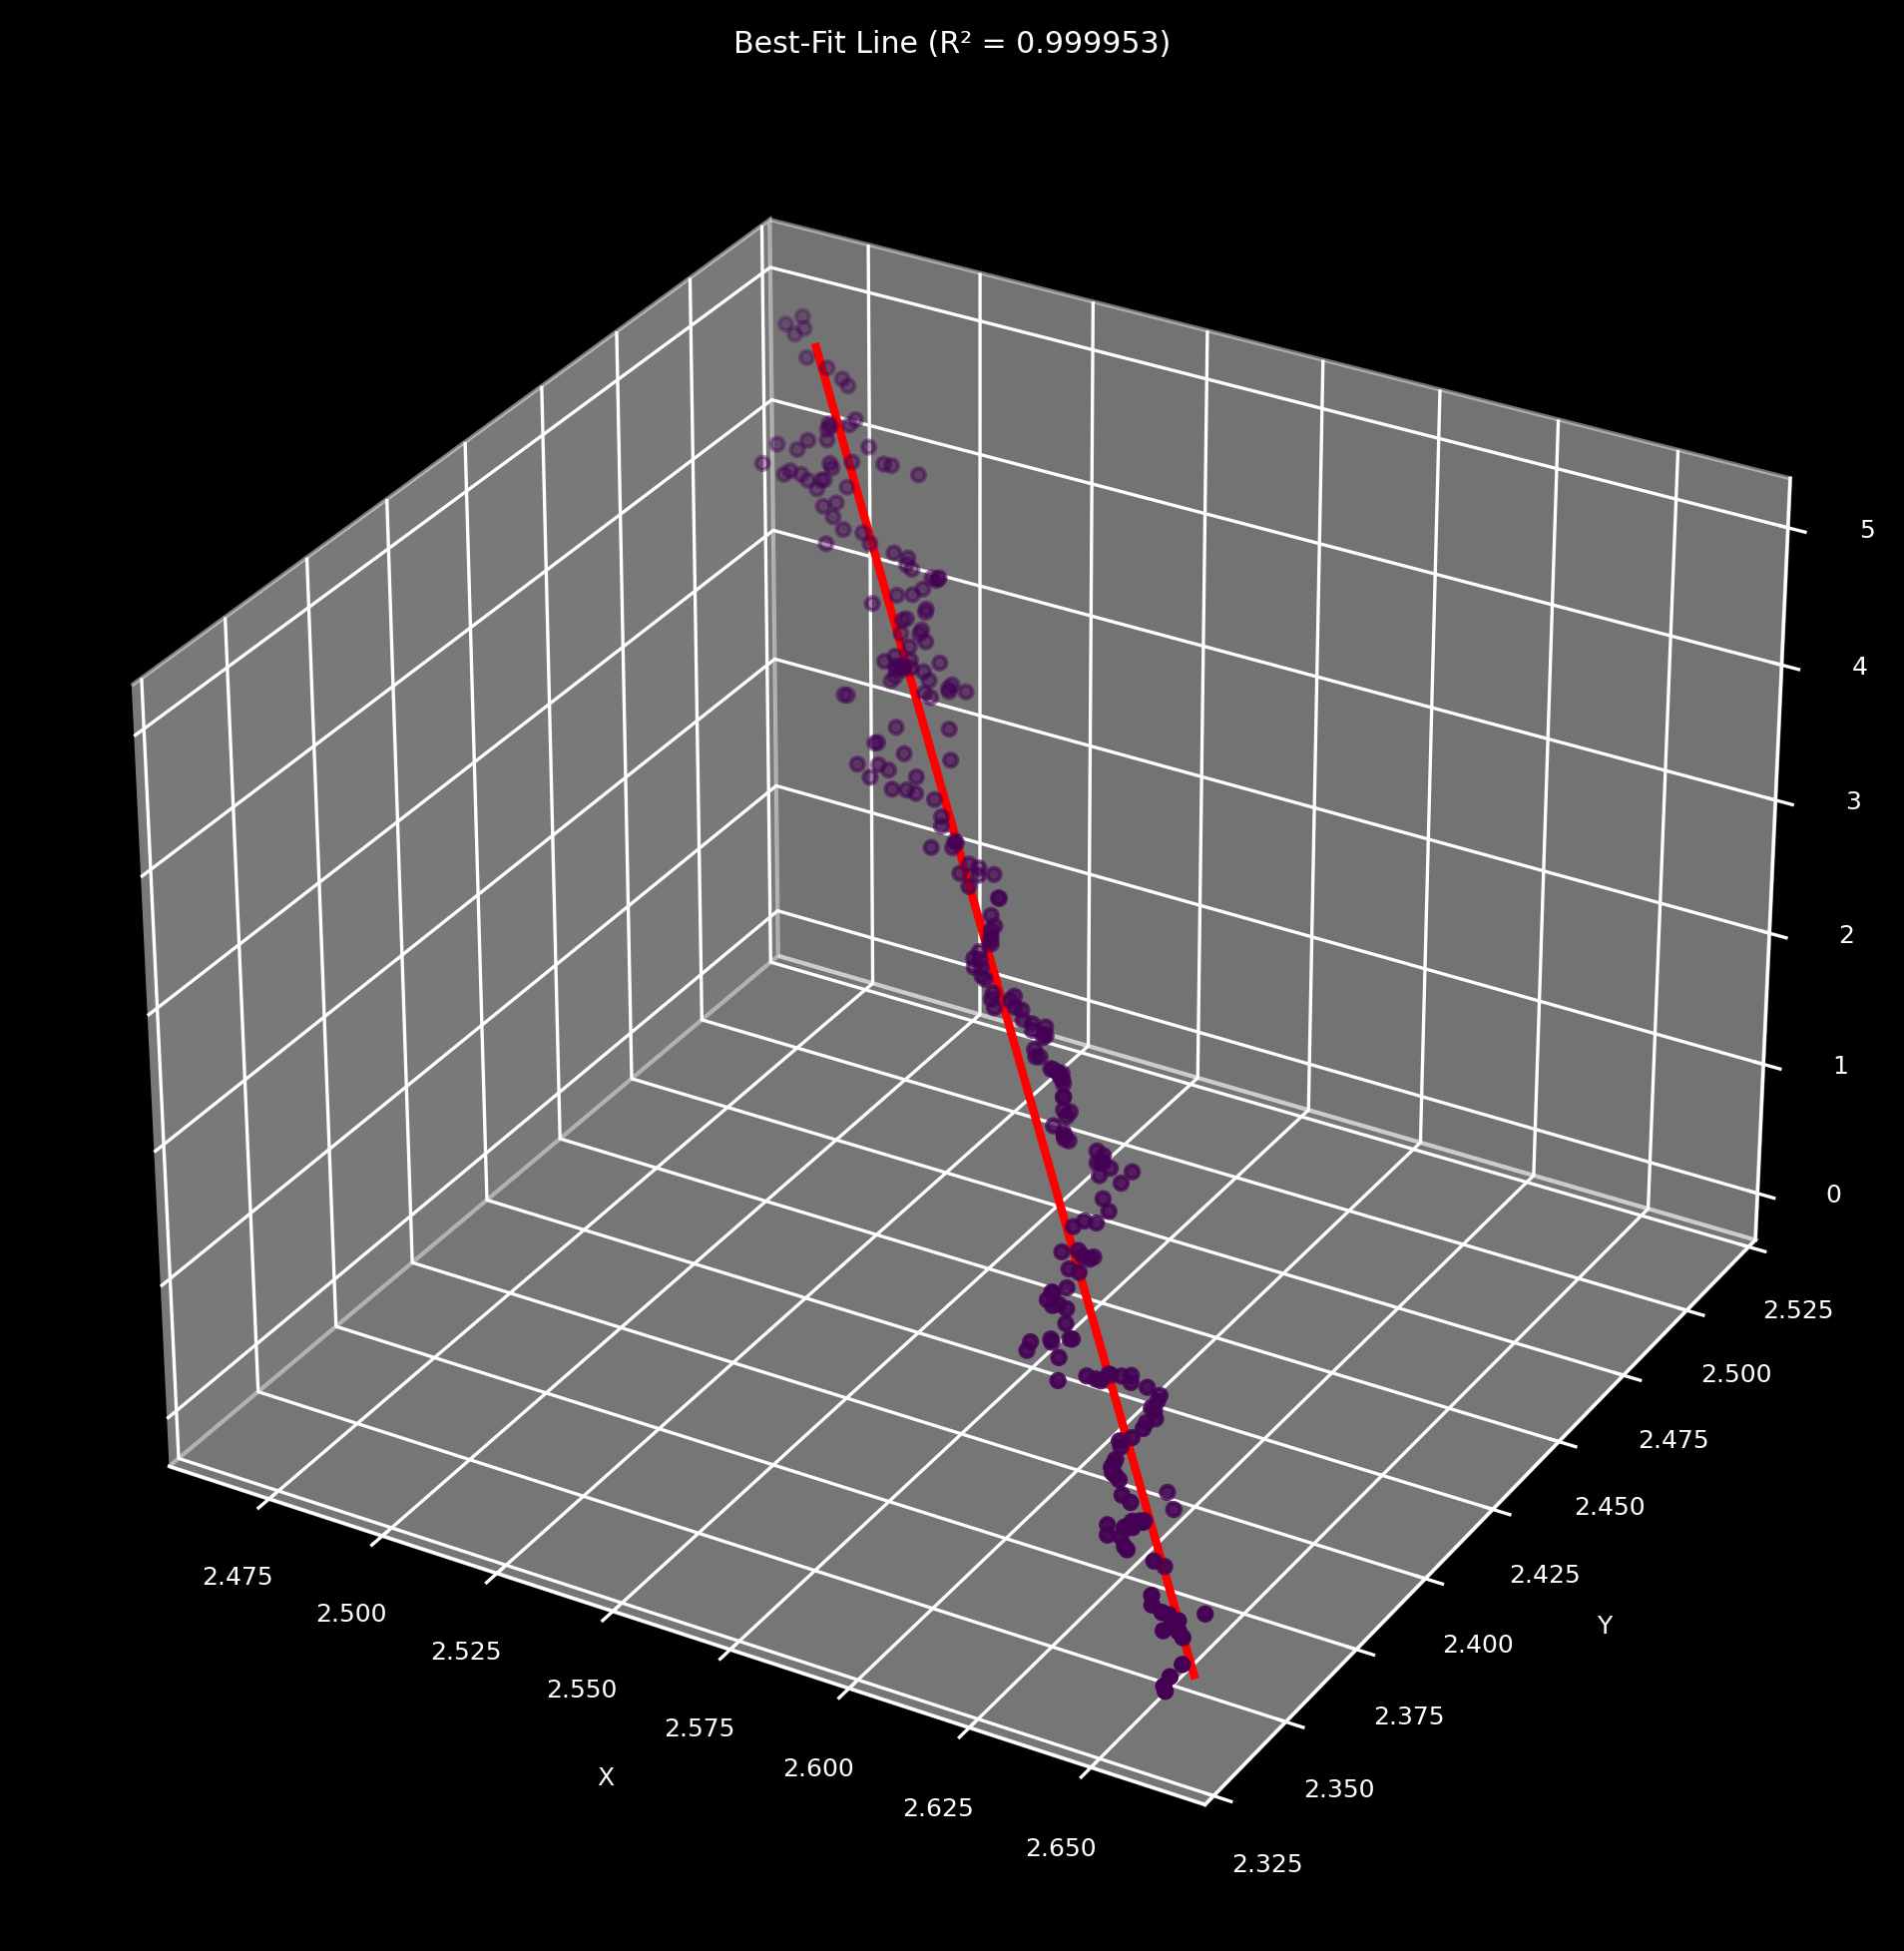

In [16]:
# Barycenters
G = np.array(G_list)
G = G * vs[0]

centroid_base_fit, centroid_top_fit, v_dir = best_fit_segment_3d(G)

#R^2
N = G.shape[0]
dX = G - G.mean(axis=0)
Cmat = (dX.T @ dX) / (N - 1)
U, S, _ = np.linalg.svd(Cmat)
R2 = S[0] / np.sum(S)

# Plot best-fit line with barycenters
fig = plt.figure(figsize=(10,8))
ax2 = fig.add_subplot(111, projection='3d')
ax2.plot([centroid_base_fit[0], centroid_top_fit[0]], [centroid_base_fit[1], centroid_top_fit[1]], [centroid_base_fit[2], centroid_top_fit[2]], '-r', linewidth=2)
ax2.scatter(G[:,0], G[:,1], G[:,2], c=ecc_list, cmap='viridis', s=10)
ax2.set_title(f'Best-Fit Line (R² = {R2:.6f})')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
plt.show()

In [ ]:
# np.savetxt('./../../test_data/LHDL/Ti_2923_D_1/results/G_coords.csv', G, delimiter=',')

In [17]:
print(f"Unit vector orienting the axis: [{v_dir[0]}, {v_dir[1]}, {v_dir[2]}]")
print(f"Section eccentricities — mean: {np.mean(ecc_list):.3f}, min: {np.min(ecc_list):.3f}, max: {np.max(ecc_list):.3f}, std: {np.std(ecc_list):.3f}")

Unit vector orienting the axis: [-0.036208026476437165, 0.03250730379892011, 0.9988154254007124]
Section eccentricities — mean: 1.000, min: 1.000, max: 1.000, std: 0.000


### Centroid Coordinates

In [18]:
print(f"Centroid at the base = {G[0]}")
print(f"Centroid at the top = {G[-1]}")
print('--------------------------')
print(f'Best-fit centroid at the base = {centroid_base_fit}')
print(f'Best-fit centroid at the top = {centroid_top_fit}')

Centroid at the base = [2.65720779 2.33514918 0.        ]
Centroid at the top = [2.47196842 2.50975315 4.992     ]
--------------------------
Best-fit centroid at the base = [ 2.65914928e+00  2.34175826e+00 -1.44717413e-04]
Best-fit centroid at the top = [2.47816455 2.50424503 4.99240388]


In [19]:
centroid_base_fit

array([ 2.65914928e+00,  2.34175826e+00, -1.44717413e-04])

## Generate mask of the inscribed cylinder 

In [35]:
# Interpolate centroid positions along the Z-axis
from scipy.interpolate import interp1d
interp_func = interp1d([0, BW.shape[0]-1], [centroid_base_fit, centroid_top_fit], axis=0)
centroid_c = interp_func(z_levels)/vs

In [36]:
s, h, w = BW.shape
y, x = np.ogrid[:h, :w]
BW_cyl = np.zeros_like(BW, dtype=bool)
centroid_base_fit/vs

# Circular mask creation
for z in range(s):
    BW_cyl[z] = (x - centroid_c[z,0])**2 + (y - centroid_c[z,1])**2 <= r_list[z]**2

## Compute trabecular metrics

### Bone Volume Fraction (BV/TV)

The bone volume fraction (**BV/TV**) is calculated as the ratio between the segmented bone volume and the total volume of the scanned region.

In [49]:
total_volume = np.sum(BW_cyl) * vs[2]**3
print(f'Total volume = {total_volume:.2f} mm^3')

bone_volume = np.sum(BW) * vs[2]**3
print(f'Sample volume = {bone_volume:.2f} mm^3')

BVTV = (bone_volume/total_volume)
print(f"BV/TV = {100*BVTV:.2f} %")

Total volume = 97.39 mm^3
Sample volume = 20.40 mm^3
BV/TV = 20.94 %


### Trabecular thickness (Tb.Th)

In [ ]:
th_mean, th_std, _, _, _ = calc_structure_thickness_statistics(BW, vs[2], 0, skeletonize=False)
print(f"Trabecular Thickness — mean: {th_mean:.2f} mm, std: {th_std:.2f} mm")

### Trabecular separation (Tb.Sp)

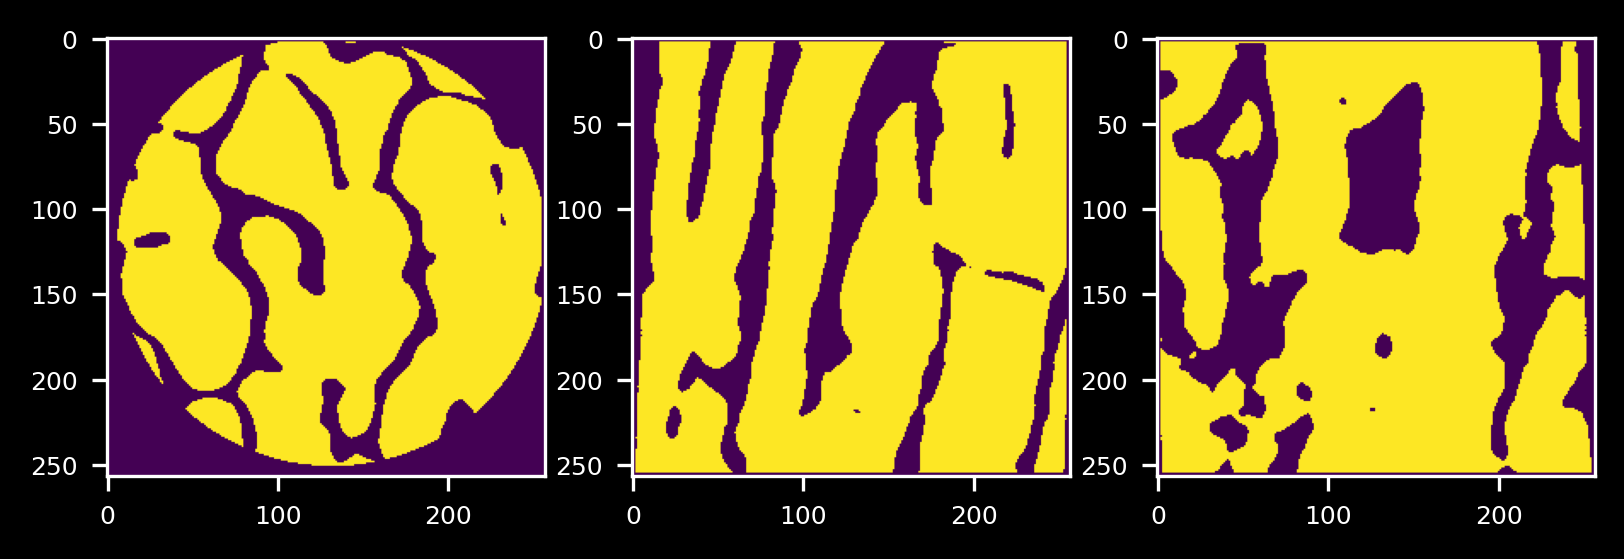

In [ ]:
from scipy.ndimage import binary_erosion
plot_midplanes(binary_erosion(BW_cyl, iterations=2) & ~BW)

In [63]:
sp_mean, sp_std, _, _, _ = calc_structure_thickness_statistics(binary_erosion(BW_cyl, iterations=2) & ~BW, vs[2], 0, skeletonize=False)
print(f"Trabecular Separation — mean: {sp_mean:.2f} mm, std: {sp_std:.2f} mm")

Trabecular Separation — mean: 0.86 mm, std: 0.23 mm


### Trabecular number (Tb.N)

In [50]:
trabecular_number = BVTV / th_mean if th_mean > 0 else 0.0
print(f"Trabecular Number = {trabecular_number:.2f} mm^-1")

Trabecular Number = 0.89 mm^-1
